<a href="https://colab.research.google.com/github/Jaseel-beep/jas2wanderlust/blob/main/ML_English_German.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import random
import string
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM, Input, Dense, Embedding, RepeatVector, TimeDistributed, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
Path = '/content/drive/MyDrive/Capstone/'
try:
    with open(Path+"news-commentary-v9.de-en.de", "r", encoding="utf-8") as german_file:
        news_german_sentences = german_file.readlines()
    with open(Path+"news-commentary-v9.de-en.en", "r", encoding="utf-8") as english_file:
        news_english_sentences = english_file.readlines()
except FileNotFoundError:
      print("Error: WMT News Commentary files not found!")
else:
      print("Successfully read WMT News Commentary sentences.")

Successfully read WMT News Commentary sentences.


In [25]:
try:
    with open(Path+"europarl-v7.de-en.de", "r", encoding="utf-8") as german_file:
        euro_german_sentences = german_file.readlines()
    with open(Path+"europarl-v7.de-en.en", "r", encoding="utf-8") as english_file:
        euro_english_sentences = english_file.readlines()
except FileNotFoundError:
    print("Error: Europarl v7 files not found!")
else:
    print("Successfully read Europarl v7 sentences.")

Successfully read Europarl v7 sentences.


In [28]:
try:
    with open(Path+"commoncrawl.de-en.de", "r", encoding="utf-8") as german_file:
        common_german_sentences = german_file.readlines()
    with open(Path+"commoncrawl.de-en.en", "r", encoding="utf-8") as english_file:
        common_english_sentences = english_file.readlines()
except FileNotFoundError:
    print("Error: Common Crawl files not found!")
else:
    print("Successfully read Common Crawl sentences.")

Successfully read Common Crawl sentences.


In [29]:
print("Number of German WMT News Commentary sentences:", len(news_german_sentences))
print("Number of English WMT News Commentary sentences:", len(news_english_sentences))
print("")
print("Number of German Europarl v7 sentences:", len(euro_german_sentences))
print("Number of English Europarl v7 sentences:", len(euro_english_sentences))
print("")
print("Number of German Common Crawl sentences:", len(common_german_sentences))
print("Number of English Common Crawl sentences:", len(common_english_sentences))

Number of German WMT News Commentary sentences: 201854
Number of English WMT News Commentary sentences: 201995

Number of German Europarl v7 sentences: 1920209
Number of English Europarl v7 sentences: 1920209

Number of German Common Crawl sentences: 2399123
Number of English Common Crawl sentences: 2399123


In [30]:
# Pad the shorter list with empty strings
news_german_sentences.extend([''] * (len(news_english_sentences) - len(news_german_sentences)))

In [31]:
# Combine German sentences
all_german_sentences = []
all_german_sentences.extend(news_german_sentences)
all_german_sentences.extend(euro_german_sentences)
all_german_sentences.extend(common_german_sentences)

# Combine English sentences
all_english_sentences = []
all_english_sentences.extend(news_english_sentences)
all_english_sentences.extend(euro_english_sentences)
all_english_sentences.extend(common_english_sentences)

print("Number of German sentences:", len(all_german_sentences))
print("Number of English sentences:", len(all_english_sentences))

Number of German sentences: 4521327
Number of English sentences: 4521327


In [32]:
# Create a DataFrame with two columns: 'German' and 'English'
Translated_df = pd.DataFrame({'German': all_german_sentences, 'English': all_english_sentences})

Translated_df.head()
print(Translated_df.shape)

(4521327, 2)


In [33]:
Translated_df.duplicated().sum()

45016

In [34]:
# Dropping duplicates
New_Translated_df = Translated_df.drop_duplicates()

In [35]:
New_Translated_df.duplicated().sum()

0

In [36]:
# Dropping NA values
Translate_df = New_Translated_df.dropna(axis=0)

In [37]:
Translate_df.isna().sum()

German     0
English    0
dtype: int64

In [38]:
Translate_df.shape

(4476311, 2)

In [39]:
# Sample 10,000 rows randomly from the DataFrame
sampled_df = Translate_df.sample(10000, random_state=42)  # Set random_state for reproducibility

print(sampled_df.shape)

(10000, 2)


Step 3: NLP pre processing - Dataset suitable to be used for AIML model learning.

In [40]:
def remove_punctuation(text):
  """Removes punctuation from a given text string."""
  # Define punctuation characters to remove
  punct = set(string.punctuation)
  text = ''.join([char for char in text if char not in punct])
  text = ''.join([char for char in text if char.isalnum() or char.isspace()])
  text = text.lower()
  # Return text with punctuation characters removed
  return text

# Apply the function to both columns using apply
sampled_df['English_Processed'] = sampled_df['English'].apply(remove_punctuation)
sampled_df['German_Processed'] = sampled_df['German'].apply(remove_punctuation)


In [41]:
sampled_df.head()

,German,English,English_Processed,German_Processed
112308,Europahistoriker werden vermutlich eines Tages...,"Indeed, countries do not compete against each ...",indeed countries do not compete against each o...,europahistoriker werden vermutlich eines tages...
4270832,Mit Wisla (POL) steht ein neuer Veranstaltungs...,Over the past years the Grand Prix became a ve...,over the past years the grand prix became a ve...,mit wisla pol steht ein neuer veranstaltungsor...
3423924,Die Bedienung ist recht einfach und übersichtl...,The interface is easy to use.\n,the interface is easy to use\n,die bedienung ist recht einfach und übersichtl...
2074842,"Es gibt jetzt in Belgien eine neue Regierung, ...",There is now a new government in Belgium which...,there is now a new government in belgium which...,es gibt jetzt in belgien eine neue regierung d...
2835004,Diese Option wurde in MySQL 5.1.4 hinzugefügt.\n,This output can be helpful for replication deb...,this output can be helpful for replication deb...,diese option wurde in mysql 514 hinzugefügt\n


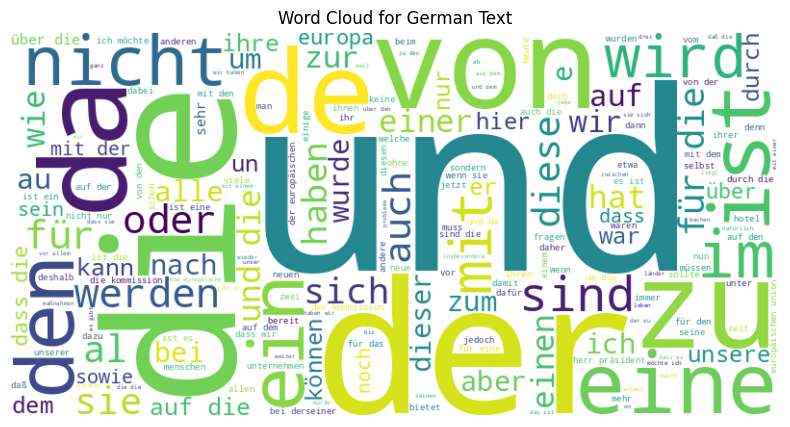

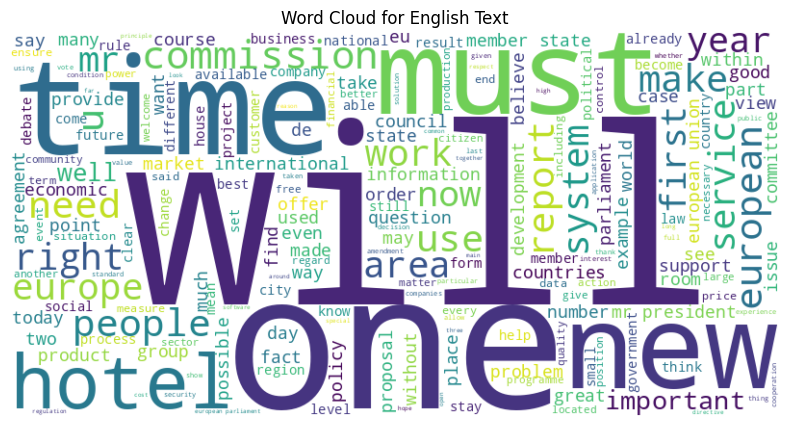

In [42]:
# Word Cloud
# Concatenate all German and English sentences into single strings
german_text = ' '.join(sampled_df['German_Processed'])
english_text = ' '.join(sampled_df['English_Processed'])

# Generate the word cloud for German text
wordcloud_german = WordCloud(width=800, height=400, background_color='white').generate(german_text)

# Generate the word cloud for English text
wordcloud_english = WordCloud(width=800, height=400, background_color='white').generate(english_text)

# Plot the word cloud for German text
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_german, interpolation='bilinear')
plt.title('Word Cloud for German Text')
plt.axis('off')
plt.show()

# Plot the word cloud for English text
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_english, interpolation='bilinear')
plt.title('Word Cloud for English Text')
plt.axis('off')
plt.show()

Step 4: Design, train and test simple RNN & LSTM model.

In [43]:
# Create separate tokenizers for German and English
german_tokenizer = Tokenizer()
english_tokenizer = Tokenizer()

# Fit tokenizers on the processed text columns (English_Processed and German_Processed)
german_tokenizer.fit_on_texts(sampled_df['German_Processed'].tolist())
english_tokenizer.fit_on_texts(sampled_df['English_Processed'].tolist())

# Convert sentences to sequences of integers
german_sequences = german_tokenizer.texts_to_sequences(sampled_df['German_Processed'].tolist())
english_sequences = english_tokenizer.texts_to_sequences(sampled_df['English_Processed'].tolist())

max_german_len = int(len(max(german_sequences,key=len)))
max_english_len = int(len(max(english_sequences,key=len)))

german_padded = pad_sequences(german_sequences, maxlen=max_german_len, padding='post')
english_padded = pad_sequences(english_sequences, maxlen=max_english_len, padding='post')

In [44]:
print('Maximum length german sentence: {}'.format(len(max(german_sequences,key=len))))
print('Maximum length english sentence: {}'.format(len(max(english_sequences,key=len))))


# Check language length
german_vocab = len(german_tokenizer.word_index) + 1
english_vocab = len(english_tokenizer.word_index) + 1

print("German vocabulary is of {} unique words".format(german_vocab))
print("English vocabulary is of {} unique words".format(english_vocab))

Maximum length german sentence: 147
Maximum length english sentence: 136
German vocabulary is of 36241 unique words
English vocabulary is of 23335 unique words


In [45]:
# Ensure that the target sequences for training are shifted by one time step
english_padded_shifted = np.pad(english_padded[:, 1:], ((0, 0), (0, 1)), 'constant')

X_train, X_test, y_train, y_test = train_test_split(german_padded, english_padded_shifted, test_size=0.2, random_state=42)

In [46]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 147)
(2000, 147)
(8000, 136)
(2000, 136)


In [47]:
# Define hyperparameters
lstm_units = 256

vocab_size_german = len(german_tokenizer.word_index) + 1  # Account for padding (0)
vocab_size_english = len(english_tokenizer.word_index) + 1

# Model definition
model = Sequential()

# Encoder
model.add(Input(shape=(max_german_len,)))
model.add(Embedding(input_dim=vocab_size_german, output_dim=128))
model.add(LSTM(lstm_units, return_sequences=False))
# Decoder
model.add(RepeatVector(max_english_len))
model.add(LSTM(lstm_units, return_sequences=True))

model.add(TimeDistributed(Dense(vocab_size_english, activation='softmax')))

# Compile the model
model.compile(loss=sparse_categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 147, 128)          4638848   
                                                                 
 lstm (LSTM)                 (None, 256)               394240    
                                                                 
 repeat_vector (RepeatVecto  (None, 136, 256)          0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 136, 256)          525312    
                                                                 
 time_distributed (TimeDist  (None, 136, 23335)        5997095   
 ributed)                                                        
                                                                 
Total params: 11555495 (44.08 MB)
Trainable params: 1155

In [48]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history = model.fit(X_train,
                            np.expand_dims(y_train, -1),
                            batch_size=128,
                            epochs=10,
                            validation_data=(X_test, np.expand_dims(y_test, -1)),
                            callbacks=[early_stopping])

print("Model training completed successfully!")

Epoch 1/10
63/63 [==============================] - 51s 656ms/step - loss: 3.3231 - accuracy: 0.8254 - val_loss: 1.5786 - val_accuracy: 0.8399
Epoch 2/10
63/63 [==============================] - 41s 660ms/step - loss: 1.4265 - accuracy: 0.8388 - val_loss: 1.3635 - val_accuracy: 0.8399
Epoch 3/10
63/63 [==============================] - 43s 686ms/step - loss: 1.3594 - accuracy: 0.8388 - val_loss: 1.3526 - val_accuracy: 0.8399
Epoch 4/10
63/63 [==============================] - 41s 658ms/step - loss: 1.3508 - accuracy: 0.8388 - val_loss: 1.3542 - val_accuracy: 0.8399
Epoch 5/10
63/63 [==============================] - 43s 687ms/step - loss: 1.3438 - accuracy: 0.8388 - val_loss: 1.3541 - val_accuracy: 0.8399
Epoch 6/10
63/63 [==============================] - 43s 679ms/step - loss: 1.3403 - accuracy: 0.8392 - val_loss: 1.3542 - val_accuracy: 0.8408
Epoch 6: early stopping
Model training completed successfully!


In [49]:
train_loss, train_accuracy = model.evaluate(X_train, np.expand_dims(y_train, -1))
test_loss, test_accuracy = model.evaluate(X_test, np.expand_dims(y_test, -1))

print(f"Training Loss: {train_loss}, Training Accuracy: {train_accuracy}")
print(f"Validation Loss: {test_loss}, Validation Accuracy: {test_accuracy}")

63/63 [==============================] - 5s 82ms/step - loss: 1.3542 - accuracy: 0.8408
Training Loss: 1.3307849168777466, Training Accuracy: 0.8396645188331604
Validation Loss: 1.354222297668457, Validation Accuracy: 0.8407573699951172


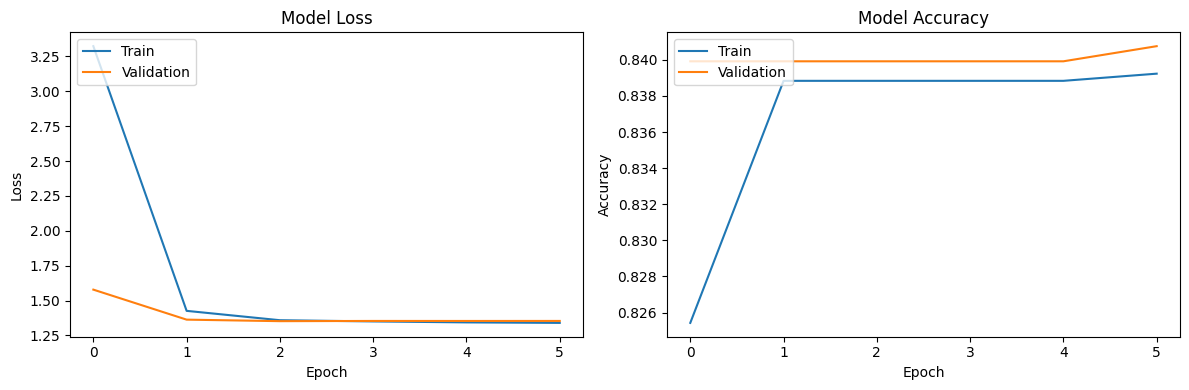

In [50]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [51]:
# Define hyperparameters
lstm_units = 128

vocab_size_german = len(german_tokenizer.word_index) + 1  # Account for padding (0)
vocab_size_english = len(english_tokenizer.word_index) + 1

# Model definition
model2 = Sequential()

# Encoder
model2.add(Input(shape=(max_german_len,)))
model2.add(Embedding(input_dim=vocab_size_german, output_dim=128))
model2.add(LSTM(256, return_sequences=True))
model2.add(LSTM(128, return_sequences=True))  # Output with sequence dimension
model2.add(LSTM(64, return_sequences=False))  # Final LSTM (no sequence dimension required)

# Decoder
model2.add(RepeatVector(max_english_len))

model2.add(LSTM(lstm_units, return_sequences=True))  # Stack multiple LSTMs
model2.add(LSTM(256, return_sequences=True))
model2.add(LSTM(128, return_sequences=True))
model2.add(LSTM(64, return_sequences=True))  # Final LSTM for decoder
model2.add(TimeDistributed(Dense(vocab_size_english, activation='softmax')))

# Compile the model
model2.compile(loss=sparse_categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 147, 128)          4638848   
                                                                 
 lstm_2 (LSTM)               (None, 147, 256)          394240    
                                                                 
 lstm_3 (LSTM)               (None, 147, 128)          197120    
                                                                 
 lstm_4 (LSTM)               (None, 64)                49408     
                                                                 
 repeat_vector_1 (RepeatVec  (None, 136, 64)           0         
 tor)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 136, 128)          98816     
                                                      

In [52]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

learning_rate_factor = 0.2  # Reduce by 80%
patience = 2  # Wait for 2 epochs of no improvement

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=learning_rate_factor, patience=patience, min_lr=0.0001)

In [53]:
history = model2.fit(X_train,
                            np.expand_dims(y_train, -1),
                            batch_size=156,
                            epochs=15,
                            validation_data=(X_test, np.expand_dims(y_test, -1)),
                     callbacks=[reduce_lr]
                    )

print("Model training completed successfully!")

Epoch 1/15
52/52 [==============================] - 56s 815ms/step - loss: 7.3047 - accuracy: 0.8224 - val_loss: 3.9953 - val_accuracy: 0.8399 - lr: 0.0010
Epoch 2/15
52/52 [==============================] - 40s 768ms/step - loss: 2.3058 - accuracy: 0.8388 - val_loss: 1.6413 - val_accuracy: 0.8399 - lr: 0.0010
Epoch 3/15
52/52 [==============================] - 40s 761ms/step - loss: 1.6137 - accuracy: 0.8388 - val_loss: 1.5803 - val_accuracy: 0.8399 - lr: 0.0010
Epoch 4/15
52/52 [==============================] - 38s 725ms/step - loss: 1.5365 - accuracy: 0.8388 - val_loss: 1.4585 - val_accuracy: 0.8399 - lr: 0.0010
Epoch 5/15
52/52 [==============================] - 39s 746ms/step - loss: 1.4267 - accuracy: 0.8388 - val_loss: 1.3918 - val_accuracy: 0.8399 - lr: 0.0010
Epoch 6/15
52/52 [==============================] - 37s 715ms/step - loss: 1.3831 - accuracy: 0.8388 - val_loss: 1.3654 - val_accuracy: 0.8399 - lr: 0.0010
Epoch 7/15
52/52 [==============================] - 39s 742ms/st

In [54]:
from tensorflow.keras.optimizers import legacy
# from tensorflow.keras.optimizers import Adam, schedules

learning_rate_initial = 0.001
decay_rate = 0.9  # Reduce by 10% each epoch

Optimizer = legacy.Adam(learning_rate=learning_rate_initial, decay=decay_rate)

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam

# Define hyperparameters
rnn_units = 128

vocab_size_german = len(german_tokenizer.word_index) + 1  # Account for padding (0)
vocab_size_english = len(english_tokenizer.word_index) + 1

# Model definition
model3 = Sequential()

# Encoder
model3.add(Input(shape=(max_german_len,)))
model3.add(Embedding(input_dim=vocab_size_german, output_dim=128))
model3.add(SimpleRNN(rnn_units, return_sequences=True))  # Output with sequence dimension
model3.add(SimpleRNN(rnn_units, return_sequences=False))
# Decoder
model3.add(RepeatVector(max_english_len))
model3.add(SimpleRNN(rnn_units, return_sequences=True))
model3.add(SimpleRNN(rnn_units, return_sequences=True))
model3.add(TimeDistributed(Dense(vocab_size_english, activation='softmax')))

# Compile the model
model3.compile(loss=sparse_categorical_crossentropy, optimizer=Optimizer, metrics=['accuracy'])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 147, 128)          4638848   
                                                                 
 simple_rnn (SimpleRNN)      (None, 147, 128)          32896     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               32896     
                                                                 
 repeat_vector_2 (RepeatVec  (None, 136, 128)          0         
 tor)                                                            
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 136, 128)          32896     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 136, 128)          32896     
                                                      

In [56]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history = model3.fit(X_train,
                            np.expand_dims(y_train, -1),
                            batch_size=256,
                            epochs=15,
                            validation_data=(X_test, np.expand_dims(y_test, -1)),
                     callbacks=[reduce_lr]
                    )

print("Model training completed successfully!")

Epoch 1/15
32/32 [==============================] - 60s 2s/step - loss: 9.3815 - accuracy: 0.7851 - val_loss: 9.1058 - val_accuracy: 0.8399 - lr: 0.0010
Epoch 2/15
32/32 [==============================] - 55s 2s/step - loss: 8.9984 - accuracy: 0.8388 - val_loss: 8.9011 - val_accuracy: 0.8399 - lr: 0.0010
Epoch 3/15
32/32 [==============================] - 55s 2s/step - loss: 8.8399 - accuracy: 0.8388 - val_loss: 8.7793 - val_accuracy: 0.8399 - lr: 0.0010
Epoch 4/15
32/32 [==============================] - 60s 2s/step - loss: 8.7372 - accuracy: 0.8388 - val_loss: 8.6934 - val_accuracy: 0.8399 - lr: 0.0010
Epoch 5/15
32/32 [==============================] - 55s 2s/step - loss: 8.6615 - accuracy: 0.8388 - val_loss: 8.6273 - val_accuracy: 0.8399 - lr: 0.0010
Epoch 6/15
32/32 [==============================] - 55s 2s/step - loss: 8.6017 - accuracy: 0.8388 - val_loss: 8.5736 - val_accuracy: 0.8399 - lr: 0.0010
Epoch 7/15
32/32 [==============================] - 54s 2s/step - loss: 8.5523 - a

English to German

In [58]:
german_padded_shifted = np.pad(german_padded[:, 1:], ((0, 0), (0, 1)), 'constant')

X_train, X_test, y_train, y_test = train_test_split(english_padded, german_padded_shifted, test_size=0.2, random_state=42)


In [59]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 136)
(2000, 136)
(8000, 147)
(2000, 147)


In [60]:
# Define hyperparameters
lstm_units = 128

vocab_size_german = len(german_tokenizer.word_index) + 1  # Account for padding (0)
vocab_size_english = len(english_tokenizer.word_index) + 1

# Model definition
model5 = Sequential()

# Encoder
model5.add(Input(shape=(max_english_len,)))
model5.add(Embedding(input_dim=vocab_size_german, output_dim=128))
model5.add(LSTM(lstm_units, return_sequences=False))
# Decoder
model5.add(RepeatVector(max_german_len))
model5.add(LSTM(lstm_units, return_sequences=True))

model5.add(TimeDistributed(Dense(vocab_size_german, activation='softmax')))

# Compile the model
model5.compile(loss=sparse_categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

model5.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 136, 128)          4638848   
                                                                 
 lstm_9 (LSTM)               (None, 128)               131584    
                                                                 
 repeat_vector_3 (RepeatVec  (None, 147, 128)          0         
 tor)                                                            
                                                                 
 lstm_10 (LSTM)              (None, 147, 128)          131584    
                                                                 
 time_distributed_3 (TimeDi  (None, 147, 36241)        4675089   
 stributed)                                                      
                                                                 
Total params: 9577105 (36.53 MB)
Trainable params: 957

In [61]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history = model5.fit(X_train,
                            np.expand_dims(y_train, -1),
                            batch_size=128,
                            epochs=10,
                            validation_data=(X_test, np.expand_dims(y_test, -1)),
                            callbacks=[early_stopping])

print("Model training completed successfully!")

Epoch 1/10
63/63 [==============================] - 69s 1s/step - loss: 4.9855 - accuracy: 0.8485 - val_loss: 1.5204 - val_accuracy: 0.8616
Epoch 2/10
63/63 [==============================] - 62s 993ms/step - loss: 1.4474 - accuracy: 0.8624 - val_loss: 1.3555 - val_accuracy: 0.8616
Epoch 3/10
63/63 [==============================] - 62s 993ms/step - loss: 1.2947 - accuracy: 0.8624 - val_loss: 1.2832 - val_accuracy: 0.8616
Epoch 4/10
63/63 [==============================] - 58s 924ms/step - loss: 1.2557 - accuracy: 0.8624 - val_loss: 1.2742 - val_accuracy: 0.8616
Epoch 5/10
63/63 [==============================] - 62s 991ms/step - loss: 1.2441 - accuracy: 0.8624 - val_loss: 1.2642 - val_accuracy: 0.8616
Epoch 6/10
63/63 [==============================] - 58s 925ms/step - loss: 1.2362 - accuracy: 0.8624 - val_loss: 1.2619 - val_accuracy: 0.8616
Epoch 7/10
63/63 [==============================] - 58s 923ms/step - loss: 1.2314 - accuracy: 0.8624 - val_loss: 1.2612 - val_accuracy: 0.8616
Ep

In [62]:
train_loss, train_accuracy = model5.evaluate(X_train, np.expand_dims(y_train, -1))
test_loss, test_accuracy = model5.evaluate(X_test, np.expand_dims(y_test, -1))

print(f"Training Loss: {train_loss}, Training Accuracy: {train_accuracy}")
print(f"Validation Loss: {test_loss}, Validation Accuracy: {test_accuracy}")

63/63 [==============================] - 8s 122ms/step - loss: 1.2637 - accuracy: 0.8616
Training Loss: 1.213335394859314, Training Accuracy: 0.8623682260513306
Validation Loss: 1.2636746168136597, Validation Accuracy: 0.8616190552711487


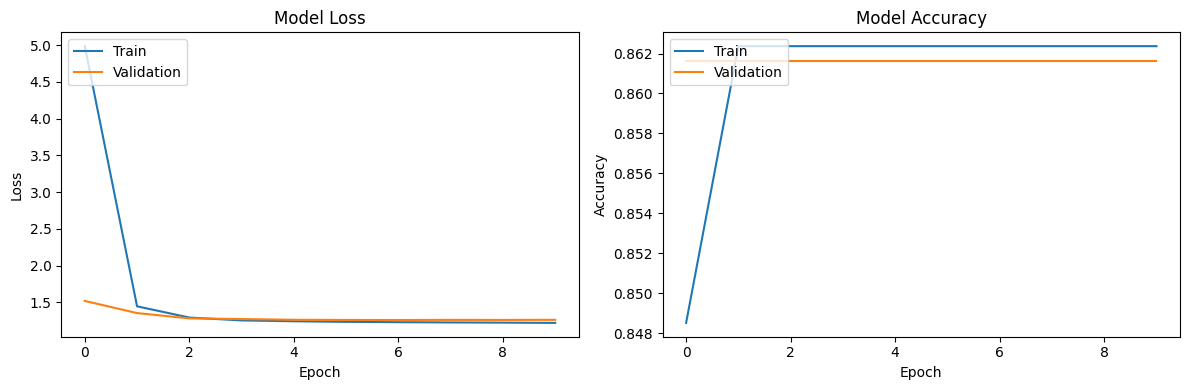

In [63]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()